# Import modules

In [1]:
import datetime
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation

# Load model collection

In [2]:
# Define model file input path
input_path = '../data/travis-county-hi-res-model.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

Text(0.5, 1.0, 'Sub-models')

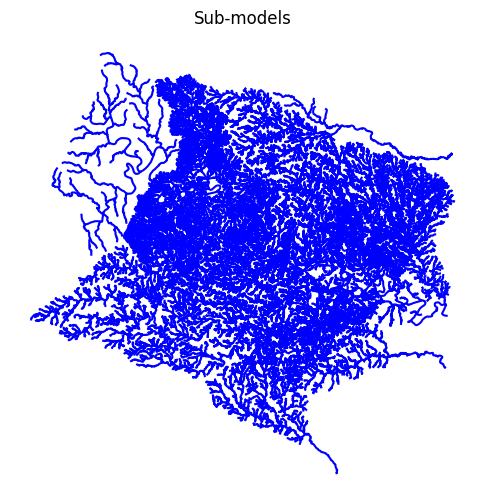

In [3]:
# Plot model collection with sub-models in different colors
fig, ax = plt.subplots(figsize=(6,6))
for model_name, model in model_collection.models.items():
    model.plot(ax=ax, c='b')
plt.axis('off')
plt.title('Sub-models')

# Create model inputs

### Load NWM forcings

In [4]:
# Define path for NWM forcings
forcing_path = '../data/20220822_event'
# Required NWM variables
nwm_vars = ['qBucket', 'qSfcLatRunoff', 'streamflow']
# Date range to load
date_list = pd.date_range('20220822', '20220824', freq='h', tz='utc')[:-1]

# Loop through HDF5 files and load forcings into memory
streamflows = []
runoffs = []
buckets = []
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qBucket')
    streamflows.append(streamflow)
    runoffs.append(runoff)
    buckets.append(bucket)
# Concatenate all forcings into single dataframe
streamflow = pd.concat(streamflows)
runoff = pd.concat(runoffs)
bucket = pd.concat(buckets)
# Lateral inflow at each reach is equal to runoff plus bucket recharge
forcing = runoff + bucket

# Ensure no duplicate entries
forcing = forcing.groupby(level=0).mean()
streamflow = streamflow.groupby(level=0).mean()

# Format column types
forcing.columns = forcing.columns.astype(str)
streamflow.columns = forcing.columns.astype(str)

### Create inputs to model based on forcings

In [5]:
# Create input table with lateral overflow into each modeled reach
input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
input_index = forcing.index.copy()
inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

# Fill input table with forcings for each reach
store = pd.HDFStore('../data/area_fractions.h5', 'r')
hdf_keys = store.keys()
store.close()
for key in hdf_keys:
    comid = key.split('__')[-1]
    area_ratios = pd.read_hdf(f'../data/area_fractions.h5', key=key)
    for reach_id in area_ratios.index:
        if comid in forcing.columns:
            runoff_proportion = area_ratios.loc[reach_id].item() * forcing[comid]
            reach_id_str = str(reach_id)
            if reach_id_str in inputs.columns:
                inputs[reach_id_str] += runoff_proportion

# Add inflow to upstream boundary reaches
upstream_inputs = {
    '5779305' : '5781161',
    '5785187' : '5785899',
    '5786029' : '5785351'
}
for downstream_reach, upstream_reach in upstream_inputs.items():
    inputs[downstream_reach] += streamflow[upstream_reach]

In [6]:
# Resample forcing input table to frequency of model timestep
dt = model_collection.timedelta.seconds
inputs = inputs.resample(f'{dt}s').mean()
inputs = inputs.interpolate().bfill().ffill()
assert not inputs.isnull().any().any()

# Prepare and execute simulation

### Prepare model for simulation

In [7]:
# Add downstream boundaries to model
for model in model_collection.models.values():
    if not model.sinks:
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

### Simulate model

In [8]:
# Simulate models
outputs = await simulation.simulate()
# Collect outputs into a single table
outputs = pd.concat([series for series in outputs.values()], axis=1)

Text(0.5, 1.0, 'Travis County Model: Discharge response to storm event on 8/22/22')

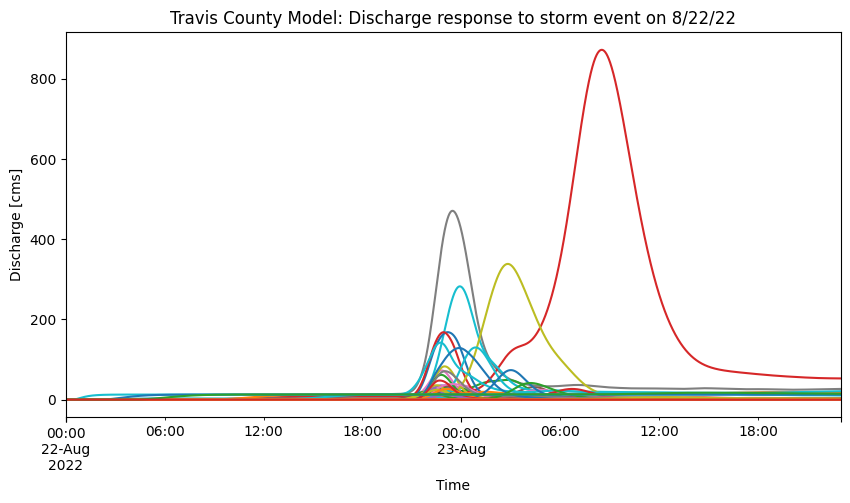

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))


for model in model_collection.models.values():
    outlet = np.asarray(model.reach_ids)[model.startnodes == model.endnodes].item()
    outputs[outlet].plot(ax=ax, legend=False)
plt.xlabel('Time')
plt.ylabel('Discharge [cms]')
plt.title('Travis County Model: Discharge response to storm event on 8/22/22')